In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import data_utils, evaluation_utils,general_utils


# Import data
df_id= pd.read_csv('./data/channel_ids_sampled.csv')
df_channels = pd.read_feather('./data/df_channels_en_sampled.feather')
df_timeseries = pd.read_feather('./data/df_timeseries_en_sampled.feather')
df_comments = pd.read_feather('./data/num_comments_sampled.feather')
df_metadata = pd.read_feather('./data/yt_metadata_en_sampled.feather')

In [2]:
# View column names and data types of each dataframe
for df_name, df in [('df_id', df_id), 
                    ('df_channels', df_channels),
                    ('df_timeseries', df_timeseries), 
                    ('df_comments', df_comments),
                    ('df_metadata', df_metadata)]:
    print(f"\n{df_name} columns:")
    print(df.info())


df_id columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13633 entries, 0 to 13632
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   channel  13633 non-null  object
dtypes: object(1)
memory usage: 106.6+ KB
None

df_channels columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13633 entries, 0 to 13632
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   category_cc         13633 non-null  object 
 1   join_date           13633 non-null  object 
 2   channel             13633 non-null  object 
 3   name_cc             13633 non-null  object 
 4   subscribers_cc      13633 non-null  int64  
 5   videos_cc           13633 non-null  int64  
 6   subscriber_rank_sb  13633 non-null  float64
 7   weights             13633 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 852.2+ KB
None

df_timeseries columns:
<clas

In [3]:
# Check missing values in each dataframe
display(pd.isna(df_channels).sum())
display(pd.isna(df_channels).sum())
display(pd.isna(df_timeseries).sum())
display(pd.isna(df_comments).sum())
display(pd.isna(df_metadata).sum())

category_cc           0
join_date             0
channel               0
name_cc               0
subscribers_cc        0
videos_cc             0
subscriber_rank_sb    0
weights               0
dtype: int64

category_cc           0
join_date             0
channel               0
name_cc               0
subscribers_cc        0
videos_cc             0
subscriber_rank_sb    0
weights               0
dtype: int64

channel         0
category        0
datetime        0
views           0
delta_views     0
subs            0
delta_subs      0
videos          0
delta_videos    0
activity        0
dtype: int64

display_id    0
num_comms     0
dtype: int64

categories            0
channel_id            0
dislike_count    171758
display_id            0
duration              0
like_count       171758
upload_date           0
view_count           33
dtype: int64

In [4]:
df_metadata=data_utils.fill_channel_means(df_metadata, ['dislike_count','like_count' ,'view_count'])
display(pd.isna(df_metadata).sum())

categories       0
channel_id       0
dislike_count    0
display_id       0
duration         0
like_count       0
upload_date      0
view_count       0
dtype: int64

# Jack of all trades or master of one 
We wonder if YouTube creators should stick to one topic or mix it up. We can investigate this by analyzing three key aspects: the impact of content diversity on channel growth and engagement, long-term performance comparison between specialized and diversified channels, and common characteristics of successful diversification strategies

In [5]:
print("Preprocessing data...")
filtered_metadata, filtered_timeseries = data_utils.preprocess_data(df_metadata, df_timeseries, 0)
    
print("Calculating channel metrics...")
merged_metrics = data_utils.calculate_channel_metrics(df_timeseries,filtered_metadata, filtered_timeseries)
print(merged_metrics.info())

Preprocessing data...
Calculating channel metrics...
<class 'pandas.core.frame.DataFrame'>
Index: 13345 entries, 0 to 13632
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   channel_id           13345 non-null  object  
 1   view_count           13345 non-null  float64 
 2   like_count           13345 non-null  float64 
 3   categories           13345 non-null  object  
 4   engagement_rate      13345 non-null  float64 
 5   diversity            13345 non-null  float64 
 6   num_categories       13345 non-null  int64   
 7   main_category        13345 non-null  object  
 8   main_category_ratio  13345 non-null  float64 
 9   sub_growth           13345 non-null  float64 
 10  weeks                13345 non-null  float64 
 11  view_growth          13345 non-null  float64 
 12  final_views          13345 non-null  float64 
 13  final_subs           13345 non-null  float64 
 14  weekly_sub_growth    1

In [6]:
print("Identifying success patterns...")
patterns, successful_channels = evaluation_utils.identify_patterns(merged_metrics)

Identifying success patterns...

=== Content Strategy Analysis Results ===

Number of successful channels: 7471
Average diversity index: 0.33
Average number of categories: 2.8
Average main category ratio: 87.2%
Average views: 664,421
Average engagement: 0.024
Average weekly subscriber growth: 2422.2
Average weekly view growth: 676904.2
Average active weeks: 132.3

Successful Strategy Characteristics:

Strategy: Specialized
Proportion: 81.4%
Weekly average subscriber growth: 2530.7
Weekly average view growth: 717,751
Content diversity: 0.18

Strategy: Mixed
Proportion: 17.2%
Weekly average subscriber growth: 1988.3
Weekly average view growth: 507,182
Content diversity: 0.91

Strategy: Diversified
Proportion: 1.5%
Weekly average subscriber growth: 1478.0
Weekly average view growth: 396,569
Content diversity: 1.53


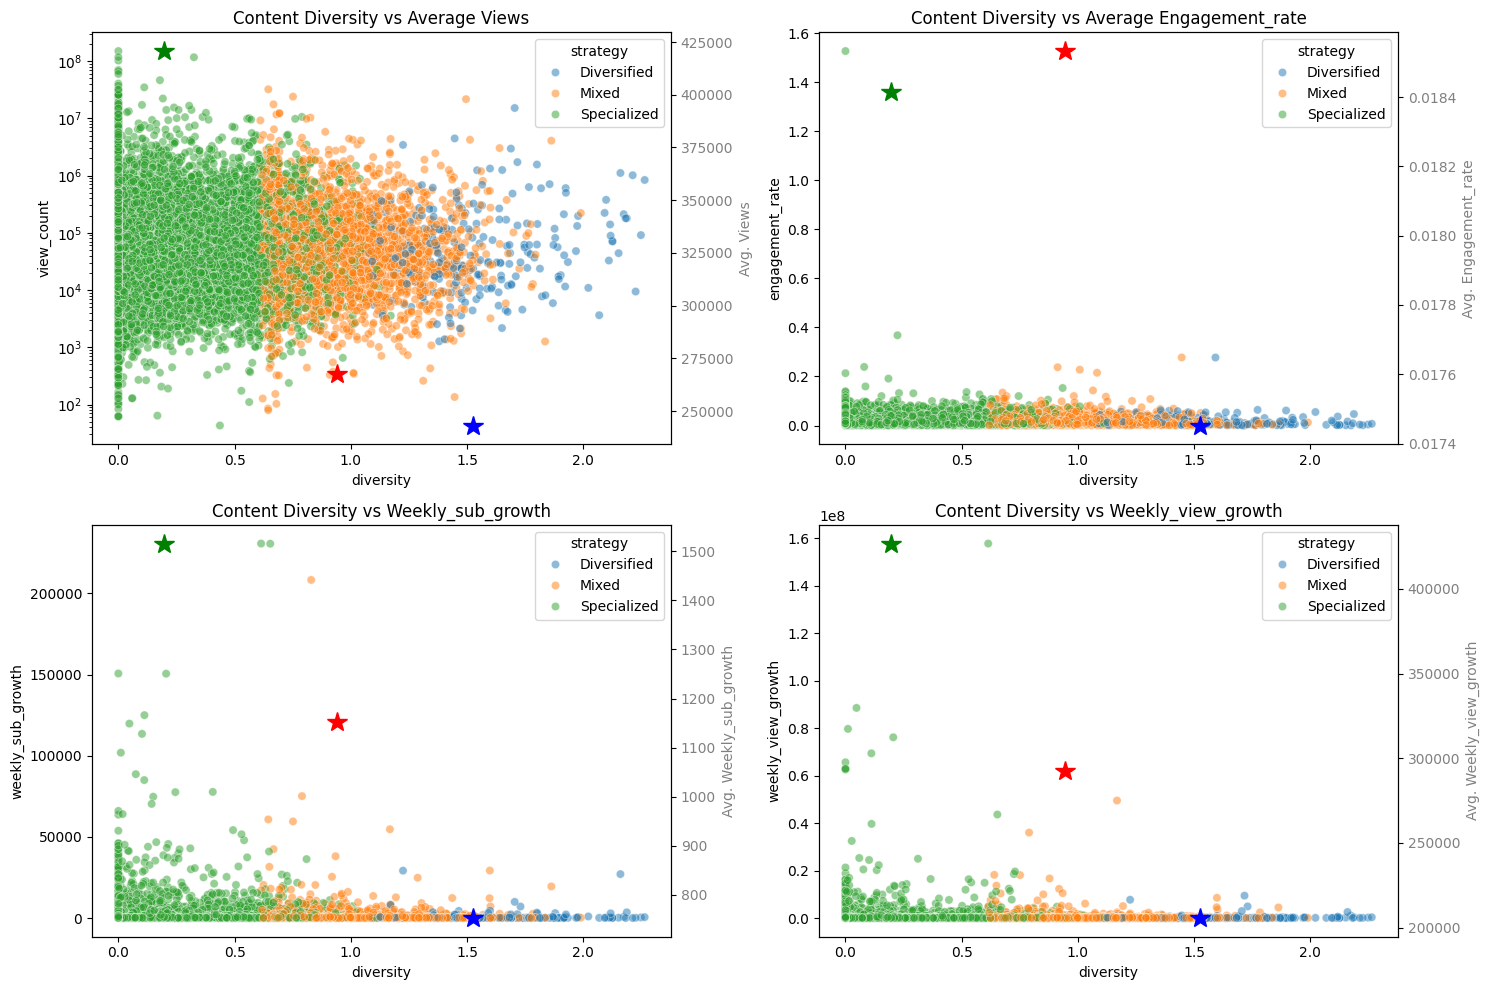

In [7]:
plot = general_utils.diversity_plot_insights(merged_metrics)
plt.show()

# Analysis of video duration
We are interested in the impact of video duration. Will people prefer a longer video as they may get more knowledge, or they prefer a short video for passing time? We can explore this by investigating three aspects: optimal video length for different categories, the impact of video length on viewer engagement and channel growth, and the evolution of audience preferences for video length over time. Also, we are going to develop a method to evaluate the popular degree of a video, then focus on the relationship between video duration and popular degree.


In [8]:
# Get analysis dataframe
df_analysis = data_utils.analyze_duration_metrics(df_metadata,df_comments,popularity_method='pca')

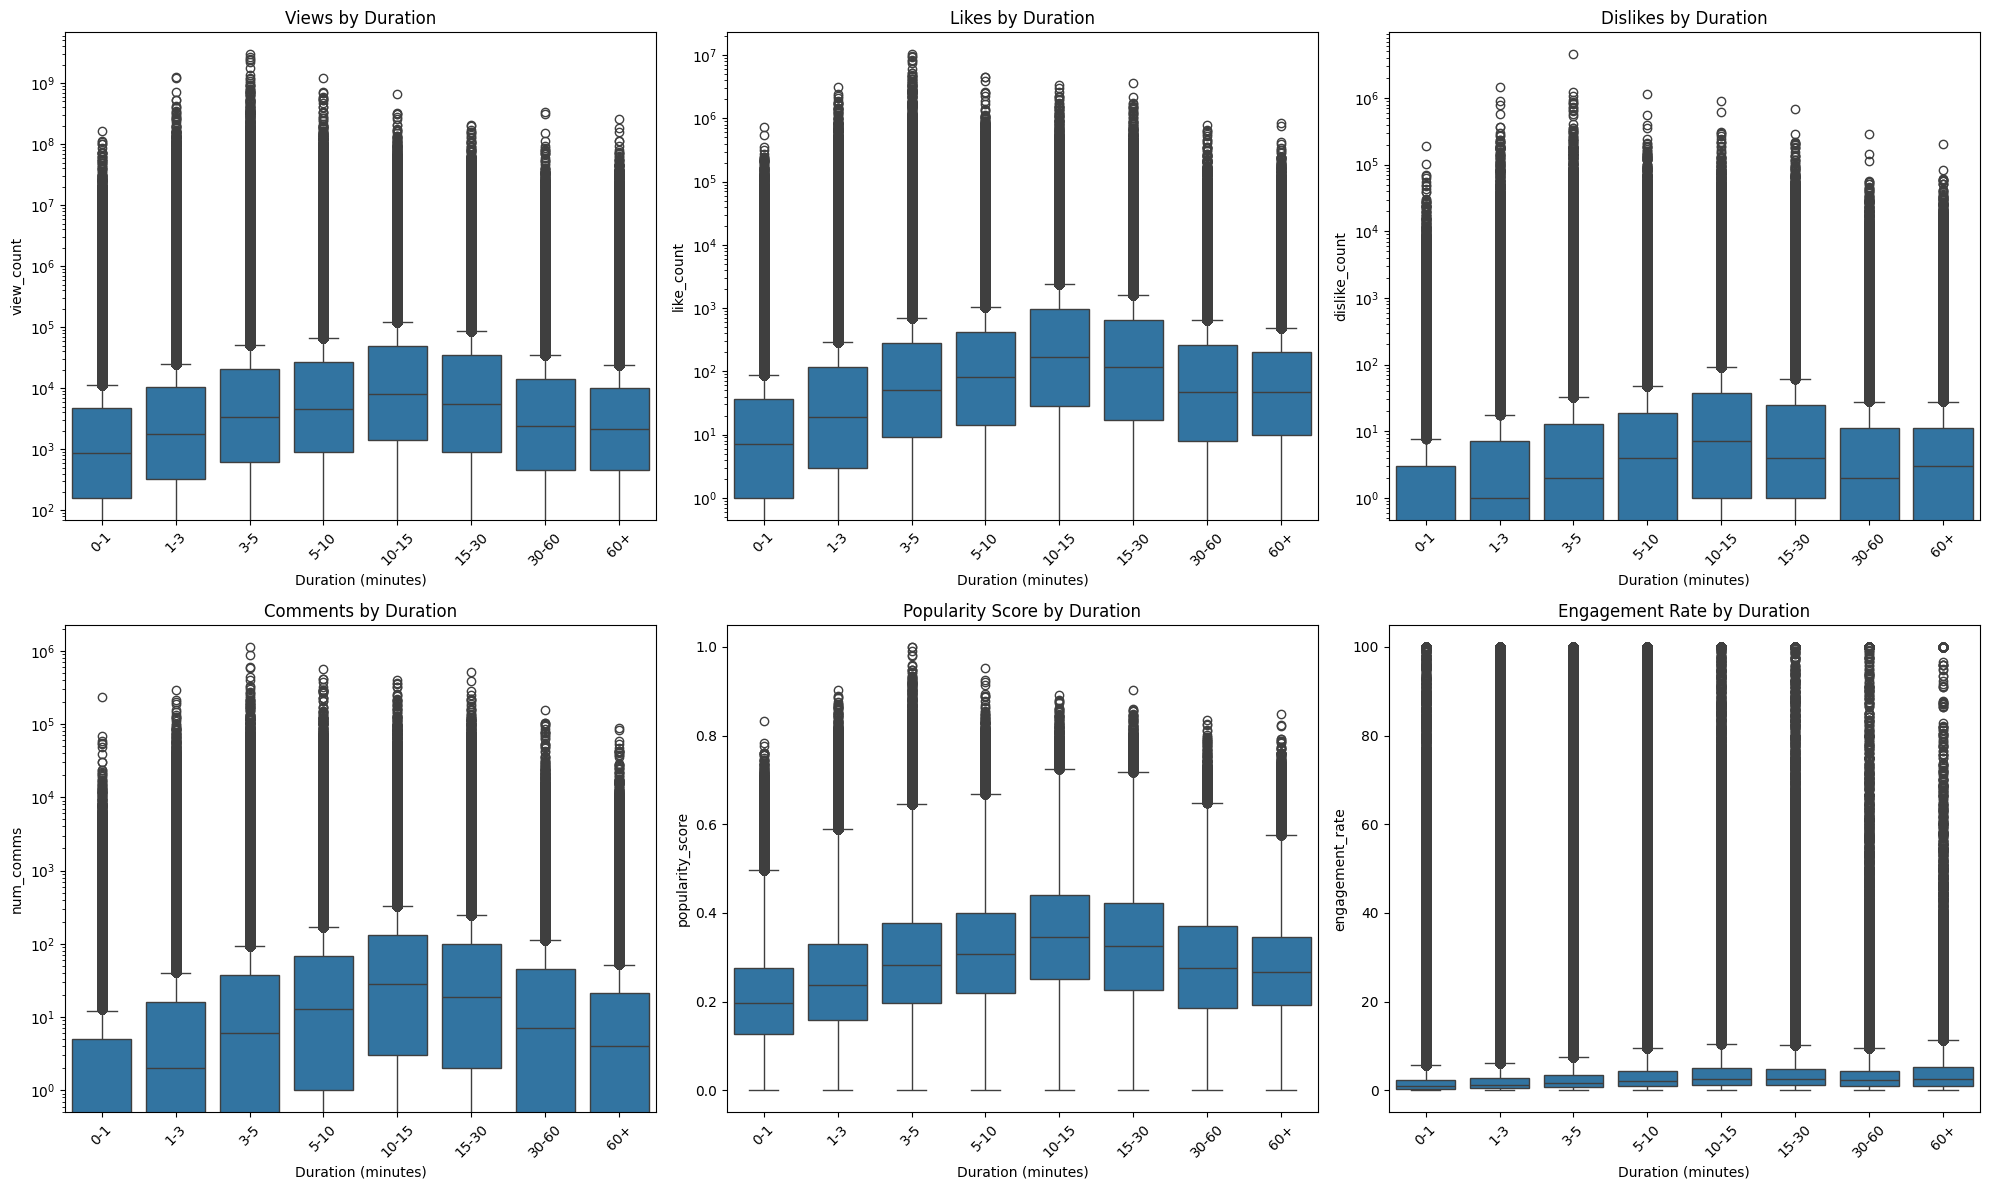

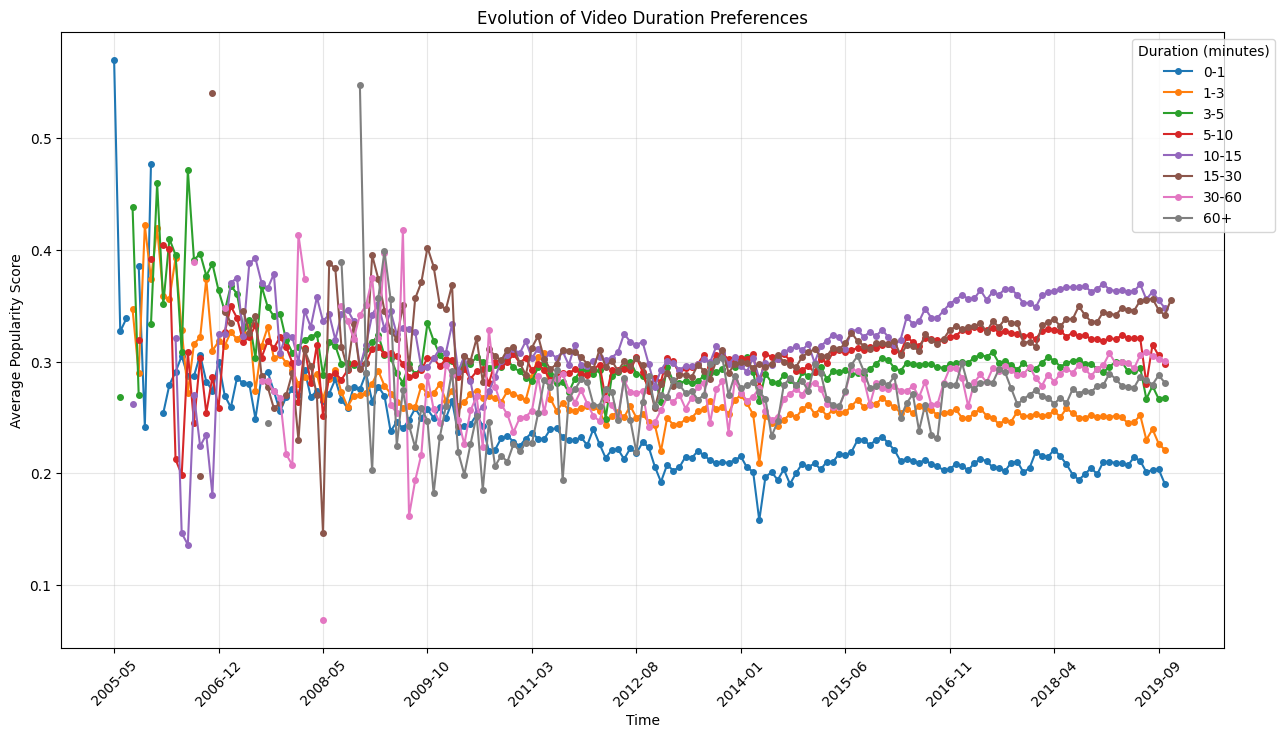

In [9]:
# Run analysis
fig_engagement, stats = general_utils.plot_engagement_metrics(df_analysis)
plt_trends = general_utils.analyze_temporal_trends(df_analysis)